In [14]:
import cv2

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:
img = cv2.imread('test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0, 0), 3)

In [ ]:
cv2.imshow('img', img)
cv2.waitKey()

In [16]:
# Face Recognition
import time
# Importing the libraries
import cv2

# Loading the cascades
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

# Defining a function that will do the detections
def detect(gray, frame):
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 3)
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 2)
    return frame

# Doing some Face Recognition with the webcam
video_capture = cv2.VideoCapture(0)

fps_start_time = 0 
fps = 0
while True:
    _, frame = video_capture.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    fps_end_time = time.time()
    time_diff = fps_end_time - fps_start_time 
    fps = 1/(time_diff)
    fps_start_time = fps_end_time
    fps_text = "FPS: {:.2F}".format(fps)
    
    canvas = detect(gray, frame)
    cv2.putText(frame, fps_text, (5, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,255), 1)
    cv2.imshow('Video', canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()

In [ ]:
import argparse
import numpy as np
import cv2 as cv
def str2bool(v):
    if v.lower() in ['on', 'yes', 'true', 'y', 't']:
        return True
    elif v.lower() in ['off', 'no', 'false', 'n', 'f']:
        return False
    else:
        raise NotImplementedError
parser = argparse.ArgumentParser()
parser.add_argument('--image1', '-i1', type=str, help='Path to the input image1. Omit for detecting on default camera.')
parser.add_argument('--image2', '-i2', type=str, help='Path to the input image2. When image1 and image2 parameters given then the program try to find a face on both images and runs face recognition algorithm.')
parser.add_argument('--video', '-v', type=str, help='Path to the input video.')
parser.add_argument('--scale', '-sc', type=float, default=1.0, help='Scale factor used to resize input video frames.')
parser.add_argument('--face_detection_model', '-fd', type=str, default='face_detection_yunet_2021dec.onnx', help='Path to the face detection model. Download the model at https://github.com/opencv/opencv_zoo/tree/master/models/face_detection_yunet')
parser.add_argument('--face_recognition_model', '-fr', type=str, default='face_recognition_sface_2021dec.onnx', help='Path to the face recognition model. Download the model at https://github.com/opencv/opencv_zoo/tree/master/models/face_recognition_sface')
parser.add_argument('--score_threshold', type=float, default=0.9, help='Filtering out faces of score < score_threshold.')
parser.add_argument('--nms_threshold', type=float, default=0.3, help='Suppress bounding boxes of iou >= nms_threshold.')
parser.add_argument('--top_k', type=int, default=5000, help='Keep top_k bounding boxes before NMS.')
parser.add_argument('--save', '-s', type=str2bool, default=False, help='Set true to save results. This flag is invalid when using camera.')
args = parser.parse_args()
def visualize(input, faces, fps, thickness=2):
    if faces[1] is not None:
        for idx, face in enumerate(faces[1]):
            print('Face {}, top-left coordinates: ({:.0f}, {:.0f}), box width: {:.0f}, box height {:.0f}, score: {:.2f}'.format(idx, face[0], face[1], face[2], face[3], face[-1]))
            coords = face[:-1].astype(np.int32)
            cv.rectangle(input, (coords[0], coords[1]), (coords[0]+coords[2], coords[1]+coords[3]), (0, 255, 0), thickness)
            cv.circle(input, (coords[4], coords[5]), 2, (255, 0, 0), thickness)
            cv.circle(input, (coords[6], coords[7]), 2, (0, 0, 255), thickness)
            cv.circle(input, (coords[8], coords[9]), 2, (0, 255, 0), thickness)
            cv.circle(input, (coords[10], coords[11]), 2, (255, 0, 255), thickness)
            cv.circle(input, (coords[12], coords[13]), 2, (0, 255, 255), thickness)
    cv.putText(input, 'FPS: {:.2f}'.format(fps), (1, 16), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
if __name__ == '__main__':
    
    detector = cv.FaceDetectorYN.create(
        args.face_detection_model,
        "",
        (320, 320),
        args.score_threshold,
        args.nms_threshold,
        args.top_k
    )
    
    tm = cv.TickMeter()
    # If input is an image
    if args.image1 is not None:
        img1 = cv.imread(cv.samples.findFile(args.image1))
        img1Width = int(img1.shape[1]*args.scale)
        img1Height = int(img1.shape[0]*args.scale)
        img1 = cv.resize(img1, (img1Width, img1Height))
        tm.start()
        
        detector.setInputSize((img1Width, img1Height))
        faces1 = detector.detect(img1)
        
        tm.stop()
        assert faces1[1] is not None, 'Cannot find a face in {}'.format(args.image1)
        # Draw results on the input image
        visualize(img1, faces1, tm.getFPS())
        # Save results if save is true
        if args.save:
            print('Results saved to result.jpg\n')
            cv.imwrite('result.jpg', img1)
        # Visualize results in a new window
        cv.imshow("image1", img1)
        if args.image2 is not None:
            img2 = cv.imread(cv.samples.findFile(args.image2))
            tm.reset()
            tm.start()
            detector.setInputSize((img2.shape[1], img2.shape[0]))
            faces2 = detector.detect(img2)
            tm.stop()
            assert faces2[1] is not None, 'Cannot find a face in {}'.format(args.image2)
            visualize(img2, faces2, tm.getFPS())
            cv.imshow("image2", img2)
            
            recognizer = cv.FaceRecognizerSF.create(
            args.face_recognition_model,"")
            
            
            face1_align = recognizer.alignCrop(img1, faces1[1][0])
            face2_align = recognizer.alignCrop(img2, faces2[1][0])
            # Extract features
            face1_feature = recognizer.feature(face1_align)
            face2_feature = recognizer.feature(face2_align)
            
            cosine_similarity_threshold = 0.363
            l2_similarity_threshold = 1.128
            
            cosine_score = recognizer.match(face1_feature, face2_feature, cv.FaceRecognizerSF_FR_COSINE)
            l2_score = recognizer.match(face1_feature, face2_feature, cv.FaceRecognizerSF_FR_NORM_L2)
            
            msg = 'different identities'
            if cosine_score >= cosine_similarity_threshold:
                msg = 'the same identity'
            print('They have {}. Cosine Similarity: {}, threshold: {} (higher value means higher similarity, max 1.0).'.format(msg, cosine_score, cosine_similarity_threshold))
            msg = 'different identities'
            if l2_score <= l2_similarity_threshold:
                msg = 'the same identity'
            print('They have {}. NormL2 Distance: {}, threshold: {} (lower value means higher similarity, min 0.0).'.format(msg, l2_score, l2_similarity_threshold))
        cv.waitKey(0)
    else: # Omit input to call default camera
        if args.video is not None:
            deviceId = args.video
        else:
            deviceId = 0
        cap = cv.VideoCapture(deviceId)
        frameWidth = int(cap.get(cv.CAP_PROP_FRAME_WIDTH)*args.scale)
        frameHeight = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)*args.scale)
        detector.setInputSize([frameWidth, frameHeight])
        while cv.waitKey(1) < 0:
            hasFrame, frame = cap.read()
            if not hasFrame:
                print('No frames grabbed!')
                break
            frame = cv.resize(frame, (frameWidth, frameHeight))
            # Inference
            tm.start()
            faces = detector.detect(frame) # faces is a tuple
            tm.stop()
            # Draw results on the input image
            visualize(frame, faces, tm.getFPS())
            # Visualize results
            cv.imshow('Live', frame)
    cv.destroyAllWindows()

In [ ]:
import cv2
import mediapipe as mp
import time


class FaceDetector():
    def __init__(self, minDetectionCon=0.5):

        self.minDetectionCon = minDetectionCon

        self.mpFaceDetection = mp.solutions.face_detection
        self.mpDraw = mp.solutions.drawing_utils
        self.faceDetection = self.mpFaceDetection.FaceDetection(self.minDetectionCon)

    def findFaces(self, img, draw=True):

        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.faceDetection.process(imgRGB)
        # print(self.results)
        bboxs = []
        if self.results.detections:
            for id, detection in enumerate(self.results.detections):
                bboxC = detection.location_data.relative_bounding_box
                ih, iw, ic = img.shape
                bbox = int(bboxC.xmin * iw), int(bboxC.ymin * ih), 
                int(bboxC.width * iw), int(bboxC.height * ih)
                bboxs.append([id, bbox, detection.score])
                if draw:
                    img = self.fancyDraw(img,bbox)

                    cv2.putText(img, f'{int(detection.score[0] * 100)}%',
                            (bbox[0], bbox[1] - 20), cv2.FONT_HERSHEY_PLAIN,
                            2, (255, 0, 255), 2)
        return img, bboxs

    def fancyDraw(self, img, bbox, l=30, t=5, rt= 1):
        x, y, w, h = bbox
        x1, y1 = x + w, y + h

        cv2.rectangle(img, bbox, (255, 0, 255), rt)
        # Top Left  x,y
        cv2.line(img, (x, y), (x + l, y), (255, 0, 255), t)
        cv2.line(img, (x, y), (x, y+l), (255, 0, 255), t)
        # Top Right  x1,y
        cv2.line(img, (x1, y), (x1 - l, y), (255, 0, 255), t)
        cv2.line(img, (x1, y), (x1, y+l), (255, 0, 255), t)
        # Bottom Left  x,y1
        cv2.line(img, (x, y1), (x + l, y1), (255, 0, 255), t)
        cv2.line(img, (x, y1), (x, y1 - l), (255, 0, 255), t)
        # Bottom Right  x1,y1
        cv2.line(img, (x1, y1), (x1 - l, y1), (255, 0, 255), t)
        cv2.line(img, (x1, y1), (x1, y1 - l), (255, 0, 255), t)
        return img


def main():
    cap = cv2.VideoCapture(0)
    pTime = 0
    detector = FaceDetector()
    while True:
        success, img = cap.read()
        img, bboxs = detector.findFaces(img)
        print(bboxs)

        cTime = time.time()
        fps = 1 / (cTime - pTime)
        pTime = cTime
        cv2.putText(img, f'FPS: {int(fps)}', (20, 70), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 2)
        cv2.imshow("Image", img)
        cv2.waitKey(1)
main()

Extracting Haar-Like Features using Scikit-Image

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

In [11]:
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)
images = lfw_subset()
# To speed up the example, extract the two types of features only
feature_types = ['type-2-x', 'type-2-y','type-3-x','type-3-y','type-4']

# Compute the result
t_start = time()
X = [extract_feature_image(img, feature_types) for img in images]
X = np.stack(X)
time_full_feature_comp = time() - t_start

# Label images (100 faces and 100 non-faces)
y = np.array([1] * 100 + [0] * 100)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

# Extract all possible features
feature_coord, feature_type = \
    haar_like_feature_coord(width=images.shape[2], height=images.shape[1],
                            feature_type=feature_types)

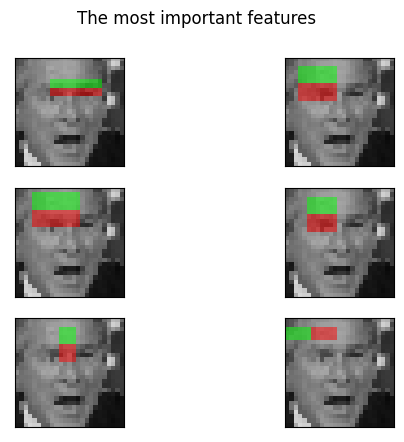

In [12]:
# Train a random forest classifier and assess its performance
clf = RandomForestClassifier(n_estimators=1000, max_depth=None,
                             max_features=100, n_jobs=-1, random_state=0)
t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
auc_full_features = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[0]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')

In [13]:
cdf_feature_importances = np.cumsum(clf.feature_importances_[idx_sorted])
cdf_feature_importances /= cdf_feature_importances[-1]  # divide by max value
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.7)
sig_feature_percent = round(sig_feature_count /
                            len(cdf_feature_importances) * 100, 1)
print(f'{sig_feature_count} features, or {sig_feature_percent}%, '
       f'account for 70% of branch points in the random forest.')

# Select the determined number of most informative features
feature_coord_sel = feature_coord[idx_sorted[:sig_feature_count]]
feature_type_sel = feature_type[idx_sorted[:sig_feature_count]]
# Note: it is also possible to select the features directly from the matrix X,
# but we would like to emphasize the usage of `feature_coord` and `feature_type`
# to recompute a subset of desired features.

# Compute the result
t_start = time()
X = [
    extract_feature_image(img, feature_type_sel, feature_coord_sel)
    for img in images
]
X = np.stack(X)
time_subs_feature_comp = time() - t_start

y = np.array([1] * 100 + [0] * 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=150,
                                                    random_state=0,
                                                    stratify=y)

802 features, or 0.4%, account for 70% of branch points in the random forest.


In [17]:
feature_coord_sel

array([list([[(5, 8), (6, 19)], [(7, 8), (8, 19)]]),
       list([[(2, 3), (5, 11)], [(6, 3), (9, 11)]]),
       list([[(1, 4), (4, 14)], [(5, 4), (8, 14)]]),
       list([[(2, 5), (5, 11)], [(6, 5), (9, 11)]]),
       list([[(2, 10), (5, 13)], [(6, 10), (9, 13)]]),
       list([[(2, 0), (4, 5)], [(2, 6), (4, 11)]]),
       list([[(3, 7), (5, 15)], [(6, 7), (8, 15)]]),
       list([[(3, 5), (5, 13)], [(6, 5), (8, 13)]]),
       list([[(3, 7), (5, 14)], [(6, 7), (8, 14)]]),
       list([[(0, 5), (5, 14)], [(6, 5), (11, 14)]]),
       list([[(3, 4), (5, 12)], [(6, 4), (8, 12)]]),
       list([[(2, 6), (5, 13)], [(6, 6), (9, 13)]]),
       list([[(3, 8), (5, 18)], [(6, 8), (8, 18)]]),
       list([[(2, 7), (5, 15)], [(6, 7), (9, 15)]]),
       list([[(2, 11), (5, 15)], [(6, 11), (9, 15)]]),
       list([[(1, 13), (5, 13)], [(6, 13), (10, 13)]]),
       list([[(5, 3), (6, 13)], [(7, 3), (8, 13)]]),
       list([[(3, 12), (5, 13)], [(6, 12), (8, 13)]]),
       list([[(3, 7), (5, 12)], [(6, 

In [7]:
i2 = integral_image(images[0])
i2

array([[  0.28888887,   0.61830065,   0.99869281,   1.50196075,
          1.98169932,   2.48627451,   3.04575166,   3.5947713 ,
          4.16209158,   4.73725501,   5.33464059,   5.94771245,
          6.54379091,   7.10457525,   7.64705887,   8.13986933,
          8.59346411,   9.03529418,   9.28758177,   9.52287589,
          9.94901969,  10.44575171,  11.16993473,  11.8692811 ,
         12.30457522],
       [  0.58300653,   1.24575165,   2.06666669,   3.0901961 ,
          4.06928107,   5.10849676,   6.22222224,   7.36993471,
          8.55294129,   9.74771258,  10.96601316,  12.21568629,
         13.44052288,  14.63398692,  15.76862743,  16.78562093,
         17.7150327 ,  18.60392159,  19.20261443,  19.76078437,
         20.51895429,  21.6130719 ,  23.15555559,  24.63267969,
         25.34640519],
       [  0.93594772,   2.01437911,   3.26274514,   4.76732031,
          6.25098047,   7.81307194,   9.46274516,  11.24575177,
         13.08235314,  14.89803943,  16.73464069,  18.6287

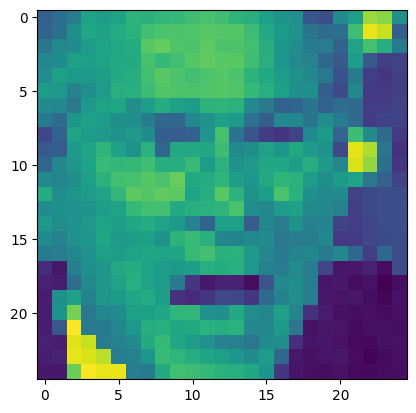

In [18]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

def show_img_

usage: ipykernel_launcher.py [-h] [--image1 IMAGE1] [--image2 IMAGE2] [--video VIDEO] [--scale SCALE]
                             [--face_detection_model FACE_DETECTION_MODEL]
                             [--face_recognition_model FACE_RECOGNITION_MODEL] [--score_threshold SCORE_THRESHOLD]
                             [--nms_threshold NMS_THRESHOLD] [--top_k TOP_K] [--save SAVE]
ipykernel_launcher.py: error: ambiguous option: -f could match -fd, -fr


SystemExit: 2

C:\Users\cspde\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3450: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
images.shape

(200, 25, 25)